# Newly trained models

In [2]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from collections import defaultdict
import warnings
import random

# Suppress warnings
warnings.filterwarnings('ignore')

SEED = 42

# Python
random.seed(SEED)
# NumPy
np.random.seed(SEED)
# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# Gymnasium (optional, but good practice)
# env.action_space.seed(SEED)

# ==========================================
# 1. LQR CONTROL & SYMMETRY DEFINITIONS
# ==========================================

class CartPoleControl:
    def __init__(self, env):
        # CartPole-v1 Parameters
        self.g = env.unwrapped.gravity
        self.mc = env.unwrapped.masscart
        self.mp = env.unwrapped.masspole
        self.lp = env.unwrapped.length
        self.mt = self.mc + self.mp
        
        # Linearize Dynamics (Exact linearization around upright)
        denom = self.lp * (4.0/3.0 - self.mp / self.mt)
        factor = 1.0 / denom
        
        # State: [x, x_dot, theta, theta_dot]
        self.A = np.zeros((4, 4))
        self.A[0, 1] = 1
        self.A[2, 3] = 1
        self.A[1, 2] = -(self.mp * self.lp / self.mt) * self.g * factor 
        self.A[3, 2] = self.g * factor                                  
        
        self.B = np.zeros((4, 1))
        self.B[1, 0] = (1.0 / self.mt) + (self.mp * self.lp / self.mt) * (1.0 / self.mt) * factor
        self.B[3, 0] = - (1.0 / self.mt) * factor

        # LQR Costs
        self.Q = np.diag([0.1, 0.01, 10.0, 0.1]) 
        self.R = np.array([[0.1]])

        # Solve Riccati
        P = linalg.solve_continuous_are(self.A, self.B, self.Q, self.R)
        self.K = np.dot(linalg.inv(self.R), np.dot(self.B.T, P))

    def get_action(self, state):
        u = -np.dot(self.K, state)
        return 1 if u > 0 else 0

class SymmetryAnalyzer:
    def __init__(self, lqr_controller):
        self.lqr = lqr_controller
        
    def check_state_symmetry(self, s1, s2, threshold=0.1):
        dist = np.linalg.norm(s1 - s2)
        dist_reflected = np.linalg.norm(s1 - (-s2))
        return (dist < threshold) or (dist_reflected < threshold)

    def check_lqr_action_symmetry(self, s1, s2):
        return self.lqr.get_action(s1) == self.lqr.get_action(s2)

    def check_model_action_symmetry(self, model, s1, s2):
        with torch.no_grad():
            a1, _ = model.predict(s1, deterministic=True)
            a2, _ = model.predict(s2, deterministic=True)
        return a1 == a2

    def generate_ground_truth_matrices(self, states, model=None):
        n = len(states)
        m_state = np.zeros((n, n))
        m_lqr = np.zeros((n, n))
        m_model = np.zeros((n, n))
        m_random = np.random.randint(0, 2, size=(n, n))  # Random binary matrix
        
        for i in range(n):
            for j in range(n):
                if self.check_state_symmetry(states[i], states[j]):
                    m_state[i, j] = 1
                if self.check_lqr_action_symmetry(states[i], states[j]):
                    m_lqr[i, j] = 1
                if model and self.check_model_action_symmetry(model, states[i], states[j]):
                    m_model[i, j] = 1
                    
        return {
            "state_sym": m_state, 
            "lqr_sym": m_lqr, 
            "model_sym": m_model,
            "random_sym": m_random # Return the random matrix
        }

# ==========================================
# 2. NETWORK ANALYSIS UTILS
# ==========================================

class NetworkProbe:
    def __init__(self, module):
        self.activations = defaultdict(list)
        self.hooks = []
        self.module = module

    def register_hooks(self):
        self.remove_hooks()
        count = 0
        for name, layer in self.module.named_modules():
            if isinstance(layer, (nn.Linear, nn.ReLU, nn.Tanh)):
                handle = layer.register_forward_hook(self._get_hook(name))
                self.hooks.append(handle)
                count += 1
        return count
            
    def _get_hook(self, name):
        def hook(model, input, output):
            if isinstance(output, torch.Tensor):
                flat = output.detach().cpu().numpy().reshape(output.shape[0], -1)
                self.activations[name].append(flat)
        return hook
    
    def clear_activations(self):
        self.activations = defaultdict(list)
        
    def remove_hooks(self):
        for h in self.hooks:
            h.remove()
        self.hooks = []
        
    def get_activation_similarity_matrix(self, layer_name, max_samples=None):
        if layer_name not in self.activations:
            return None
        
        try:
            data = np.concatenate(self.activations[layer_name], axis=0)
        except ValueError:
            return None
            
        if max_samples is not None and data.shape[0] > max_samples:
            data = data[:max_samples]
            
        data = data + np.random.normal(0, 1e-9, data.shape)
        rsm = np.corrcoef(data)
        return np.nan_to_num(rsm)
    
def analyze_similarity_groups(behavioral_matrix, neural_matrix):
    """
    Compare average neural similarity for behaviorally similar vs dissimilar states.
    """
    # Get upper triangular indices
    n = behavioral_matrix.shape[0]
    triu_indices = np.triu_indices(n, k=1)
    
    behavioral_flat = behavioral_matrix[triu_indices]
    neural_flat = neural_matrix[triu_indices]
    
    # Split into similar (1) and dissimilar (0) groups based on behavioral matrix
    similar_mask = behavioral_flat == 1
    dissimilar_mask = behavioral_flat == 0
    
    similar_neural = neural_flat[similar_mask]
    dissimilar_neural = neural_flat[dissimilar_mask]
    
    results = {
        'similar_mean': np.mean(similar_neural) if len(similar_neural) > 0 else np.nan,
        'similar_std': np.std(similar_neural) if len(similar_neural) > 0 else np.nan,
        'dissimilar_mean': np.mean(dissimilar_neural) if len(dissimilar_neural) > 0 else np.nan,
        'dissimilar_std': np.std(dissimilar_neural) if len(dissimilar_neural) > 0 else np.nan,
        'similar_count': len(similar_neural),
        'dissimilar_count': len(dissimilar_neural)
    }
    
    # Compute statistical test
    if len(similar_neural) > 0 and len(dissimilar_neural) > 0:
        from scipy.stats import ttest_ind
        t_stat, p_val = ttest_ind(similar_neural, dissimilar_neural)
        results['t_stat'] = t_stat
        results['p_val'] = p_val
    
    return results

# ==========================================
# 3. MAIN SCRIPT
# ==========================================
env = gym.make("CartPole-v1")
lqr = CartPoleControl(env)
analyzer = SymmetryAnalyzer(lqr)

print("Generating Analysis Dataset...")
sampled_states = []
while len(sampled_states) < 10000:
    s, _ = env.reset()
    sampled_states.append(s)
    for _ in range(100):
        s, _, _, _, _ = env.step(env.action_space.sample())
        sampled_states.append(s)

sampled_indices = np.random.choice(len(sampled_states), size=500, replace=False)   
sampled_states = [sampled_states[i] for i in sampled_indices]
for s in sampled_states[:]:
    sampled_states.append(-s)
    
sampled_states = np.array(sampled_states)
n_samples = len(sampled_states)
print(f"Dataset size: {n_samples} states")

policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[64, 64])
ppo_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[64, 64], vf=[64, 64]))

models = {
    "DQN": DQN("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=0, seed=42, learning_rate=1e-3),
    "PPO": PPO("MlpPolicy", env, policy_kwargs=ppo_kwargs, verbose=0, seed=42, learning_rate=3e-4)
}

results = {}

for name, model in models.items():
    if name == "DQN":
        steps = 500000
    else:
        steps = 50000
    print(f"\n{'='*30}\nTraining {name} ({steps} steps)...\n{'='*30}")
    model.learn(total_timesteps=steps)
    
    mean, std = evaluate_policy(model, env, n_eval_episodes=20, deterministic=True)
    print(f"Performance -> Mean Reward: {mean:.2f} +/- {std:.2f}")
    
    probe = NetworkProbe(model.policy)
    n_hooks = probe.register_hooks()
    print(f"Hooks registered: {n_hooks}")
    probe.clear_activations()
    
    obs_tensor = torch.as_tensor(sampled_states, device=model.device)
    with torch.no_grad():
        if name == "DQN":
            model.q_net(obs_tensor)
        else:
            model.policy.get_distribution(obs_tensor)
            
    gt = analyzer.generate_ground_truth_matrices(sampled_states, model)
    
    layer_scores = {"state": [], "lqr": [], "model": [], "random": []}
    layer_names = []
    
    all_layers = list(probe.activations.keys())
    relevant_layers = []
    if name == "DQN":
        relevant_layers = [l for l in all_layers if "q_net" in l]
    else:
        relevant_layers = [l for l in all_layers if "policy_net" in l or "action_net" in l or "value_net" in l]
        
    if not relevant_layers:
        relevant_layers = all_layers
        
    print(f"Analyzing {len(relevant_layers)} layers: {[l.split('.')[-1] for l in relevant_layers]}")
    
    indices = np.triu_indices(n_samples, k=1)
    
    for layer in relevant_layers:
        rsm = probe.get_activation_similarity_matrix(layer, max_samples=n_samples)
        if rsm is None: continue

        results_state = analyze_similarity_groups(gt["state_sym"], rsm)
        results_lqr = analyze_similarity_groups(gt["lqr_sym"], rsm)
        results_model = analyze_similarity_groups(gt["model_sym"], rsm)
        # results_random = analyze_similarity_groups(gt["random_sym"], rsm)  # Analyze random baseline
        
        layer_scores["state"].append((results_state['similar_mean'], results_state['dissimilar_mean']))
        layer_scores["lqr"].append((results_lqr['similar_mean'], results_lqr['dissimilar_mean']))
        layer_scores["model"].append((results_model['similar_mean'], results_model['dissimilar_mean']))
        # layer_scores["random"].append((results_random['similar_mean'], results_random['dissimilar_mean'])) # Store random score
        layer_names.append(layer)
        
    results[name] = (layer_names, layer_scores)
    probe.remove_hooks()

Generating Analysis Dataset...
Dataset size: 1000 states

Training DQN (500000 steps)...
Performance -> Mean Reward: 208.35 +/- 162.26
Hooks registered: 10
Analyzing 5 layers: ['0', '1', '2', '3', '4']

Training PPO (50000 steps)...
Performance -> Mean Reward: 500.00 +/- 0.00
Hooks registered: 10
Analyzing 5 layers: ['0', '1', '2', '3', 'action_net']



Generating Plots...


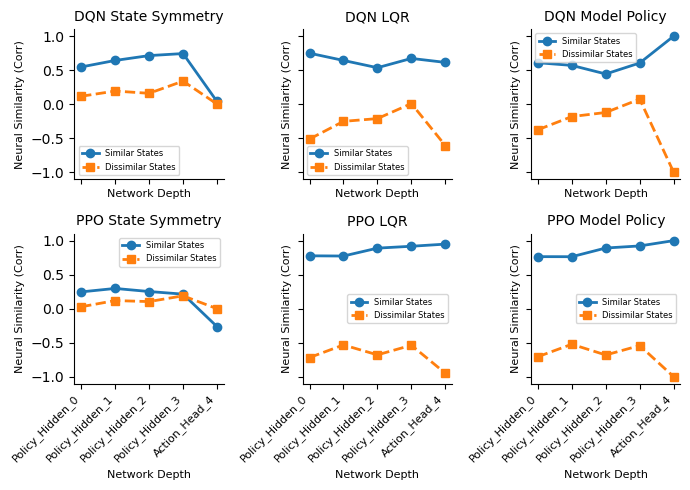

In [9]:
import seaborn as sns

def plot_panel(m, ax, layers, title):
    x = np.arange(len(layers))
    ax.plot(x, [s[0] for s in m], 'o-', label="Similar States", linewidth=2)
    ax.plot(x, [s[1] for s in m], 's--', label="Dissimilar States", linewidth=2)
    ax.set_xlabel("Network Depth", fontsize=8)
    ax.set_ylabel("Neural Similarity (Corr)", fontsize=8)
    ax.set_xticks(x)
    labels = []
    for l in layers:
        if "policy_net" in l: labels.append("Policy_Hidden")
        elif "action_net" in l: labels.append("Action_Head")
        elif "q_net" in l: labels.append("Q_Hidden" if "Linear" in l else "Act")
        else: labels.append("Layer")
    
    labels = [f"{l}_{idx}" for idx, l in enumerate(labels)]
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=6)
    ax.set_title(title, fontsize=10)

    return

# 3. Plot
print("\nGenerating Plots...")
fig, axes = plt.subplots(2, 3, figsize=(7, 5), sharex=True, sharey=True)

for (name, (layers, scores)) in results.items():

    i = 0 if name == "DQN" else 1

    m_state = np.array(scores["state"])
    plot_panel(m_state, axes[i, 0], layers, "{} State Symmetry".format(name))

    m_lqr = np.array(scores["lqr"])
    plot_panel(m_lqr, axes[i, 1], layers, "{} LQR".format(name))

    m_model = np.array(scores["model"])
    plot_panel(m_model, axes[i, 2], layers, "{} Model Policy".format(name))

sns.despine()
plt.tight_layout()
plt.savefig("inverted_pendulum_symmetry_analysis.png", dpi=300)

In [ ]:
# 3. Plot
print("\nGenerating Plots...")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, (name, (layers, scores)) in enumerate(results.items()):
    ax = axes[i]
    x = range(len(layers))
    
    labels = []
    for l in layers:
        if "policy_net" in l: labels.append("Policy_Hidden")
        elif "action_net" in l: labels.append("Action_Head")
        elif "q_net" in l: labels.append("Q_Hidden" if "Linear" in l else "Act")
        else: labels.append("Layer")
        
    labels = [f"{l}_{idx}" for idx, l in enumerate(labels)]
    
    ax.plot(x, scores["state"], 'o-', label="State Sym (-s)", linewidth=2)
    ax.plot(x, scores["lqr"], 's--', label="LQR Action Sym", linewidth=2)
    ax.plot(x, scores["model"], '^-.', label="Model Action Sym", linewidth=2)
    
    # --- NEW: Plot Random Baseline ---
    # Using 'k:' (black dotted line) to distinguish it clearly
    ax.plot(x, scores["random"], 'k:', label="Random Baseline", linewidth=2, alpha=0.6)
    
    ax.set_title(f"{name} RSA (CartPole) - R: {mean:.0f}", fontsize=14)
    ax.set_xlabel("Network Depth", fontsize=12)
    ax.set_ylabel("Similarity (Spearman)", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
plt.tight_layout()
plt.show()

In [7]:
results

{'DQN': (['q_net.q_net.0',
   'q_net.q_net.1',
   'q_net.q_net.2',
   'q_net.q_net.3',
   'q_net.q_net.4'],
  {'state': [np.float64(0.4184718463893388),
    np.float64(0.4286872873143162),
    np.float64(0.3046264270179089),
    np.float64(0.34941117955657724),
    np.float64(0.023185184748514564)],
   'lqr': [np.float64(0.43177629021330277),
    np.float64(0.3557541435919005),
    np.float64(0.45785168448512453),
    np.float64(0.4152958064063121),
    np.float64(0.0005631913782384904)],
   'model': [np.float64(0.19276321372853578),
    np.float64(0.17199195584356647),
    np.float64(0.23413594747468677),
    np.float64(0.22463892917023948),
    np.float64(0.3865489624790912)]}),
 'PPO': (['mlp_extractor.policy_net.0',
   'mlp_extractor.policy_net.1',
   'mlp_extractor.policy_net.2',
   'mlp_extractor.policy_net.3',
   'action_net'],
  {'state': [np.float64(0.35040584316965895),
    np.float64(0.3317999440582614),
    np.float64(0.15196319650415271),
    np.float64(0.14017797596342005

# Pre-trained models

In [1]:
import sys
import warnings
import numpy as np
import torch
from scipy import linalg
from sklearn.metrics.pairwise import cosine_similarity
import gymnasium as gym

# ==========================================
# 1. COMPATIBILITY & CONFIGURATION
# ==========================================
# Fix for older SB3 versions referencing 'gym' instead of 'gymnasium'
sys.modules["gym"] = gym 
warnings.filterwarnings("ignore")

try:
    from huggingface_sb3 import load_from_hub
    from stable_baselines3 import DQN, PPO
    from stable_baselines3.common.evaluation import evaluate_policy
except ImportError:
    print("Please install requirements: pip install stable-baselines3 huggingface-sb3 shimmy")

In [2]:
# ==========================================
# 2. LQR ORACLE (Fixed Physics)
# ==========================================
class LQRController:
    """
    Computes the optimal Linear Quadratic Regulator control for CartPole.
    Used as a 'ground truth' to cluster states by their optimal action.
    """
    def __init__(self, env):
        core = env.unwrapped
        # Extract physics constants
        self.g = core.gravity
        self.lp = core.length
        self.mp = core.masspole
        self.mt = core.total_mass
        self.K = self._calculate_gain()
        
    def _calculate_gain(self):
        # Linearize dynamics around the upright fixed point
        # Denominator accounts for the mass ratio effect on angular acceleration
        denom = self.lp * (4.0/3 - self.mp / self.mt)
        a = self.g / denom
        b = -1 / denom
        
        # State Matrix A: [x, x_dot, theta, theta_dot] -> derivatives
        A = np.array([
            [0, 1, 0, 0], 
            [0, 0, 0, 0], 
            [0, 0, 0, 1], 
            [0, 0, a, 0]
        ])
        
        # Control Matrix B: Force -> [x_accel, theta_accel]
        B = np.array([[0], [1/self.mt], [0], [b/self.mt]])
        
        # LQR Cost Matrices
        Q = 5 * np.eye(4) # Penalty for state deviation
        R = np.eye(1)     # Penalty for actuation effort
        
        # Solve Algebraic Riccati Equation
        P = linalg.solve_continuous_are(A, B, Q, R)
        
        # Compute Gain K = R^-1 B^T P
        return np.dot(np.linalg.inv(R), np.dot(B.T, P))
        
    def get_optimal_action(self, state):
        # u = -Kx
        u = -np.dot(self.K, state)[0]
        return 1 if u > 0 else 0

In [3]:
# ==========================================
# 3. LATENT EXTRACTION & SAMPLING
# ==========================================
def extract_representation(model, obs, target_net="default"):
    """
    Hooks into specific PyTorch layers to extract latent activations.
    target_net: 'dqn_q', 'ppo_actor', or 'ppo_critic'
    """
    obs_tensor = torch.as_tensor(obs).float().unsqueeze(0).to(model.device)
    
    # 1. Select the appropriate network
    if target_net == "dqn_q":
        # DQN Q-Network: (0) Linear -> (1) ReLU
        network = model.policy.q_net.q_net
    elif target_net == "ppo_actor":
        # PPO Policy Net: (0) Linear -> (1) Tanh
        network = model.policy.mlp_extractor.policy_net
    elif target_net == "ppo_critic":
        # PPO Value Net: (0) Linear -> (1) Tanh
        network = model.policy.mlp_extractor.value_net
    else:
        raise ValueError(f"Unknown target_net: {target_net}")

    # 2. Forward pass through the selected network
    with torch.no_grad():
        out = network[2](network[1](network[0](obs_tensor)))
    
    return out.cpu().numpy().flatten()

def collect_states(env, model, mode, n_samples):
    """
    Generates a dataset of observations based on the selected mode.
    """
    states = []
    obs, _ = env.reset()
    
    for _ in range(n_samples):
        if mode == "RANDOM":
            # Uniformly sample the state space
            current_obs = env.observation_space.sample()
            states.append(current_obs)
            # Reset occasionally to ensure coverage, though independent sampling doesn't strictly need it
            if _ % 50 == 0: obs, _ = env.reset()
            
        elif mode == "ON_POLICY":
            # Follow the model's trajectory
            states.append(obs)
            action, _ = model.predict(obs, deterministic=True)
            obs, _, term, trunc, _ = env.step(action)
            if term or trunc:
                obs, _ = env.reset()
                
    return np.array(states)

In [4]:
# ==========================================
# 4. METRIC CALCULATION
# ==========================================
def compute_cosine(v1, v2, mean=None):
    """Compute cosine similarity, optionally centering vectors."""
    v1 = v1.reshape(1, -1)
    v2 = v2.reshape(1, -1)
    
    if mean is not None:
        mean = mean.reshape(1, -1)
        v1 = v1 - mean
        v2 = v2 - mean
        
    return cosine_similarity(v1, v2)[0][0]

def compute_cluster_sim(vectors, mean=None):
    """Average pairwise similarity within a cluster of vectors."""
    if len(vectors) < 2: return 0.0
    mat = np.vstack(vectors)
    if mean is not None:
        mat = mat - mean
    sim_matrix = cosine_similarity(mat)
    # Average of upper triangle (excluding diagonal)
    return np.mean(sim_matrix[np.triu_indices(len(mat), k=1)])

def evaluate_component(model, name, target_net, env, oracle):
    print(f"\n{'='*30}\n ANALYZING: {name}\n{'='*30}")
    
    # 1. Policy Performance Check
    mean_rew, std_rew = evaluate_policy(model, env, n_eval_episodes=5, deterministic=True)
    print(f"Policy Return: {mean_rew:.1f} +/- {std_rew:.1f}")
    
    # 2. Data Collection
    print(f"Sampling {CONFIG['N_SAMPLES']} states ({CONFIG['SAMPLING_MODE']})...")
    states = collect_states(env, model, CONFIG["SAMPLING_MODE"], CONFIG["N_SAMPLES"])
    
    # 3. Compute Latents & Global Mean
    latents = [extract_representation(model, s, target_net) for s in states]
    global_mean = np.mean(latents, axis=0)
    
    # 4. Metric Loop
    metrics = {"sym_raw": [], "sym_cent": [], "glob_raw": [], "glob_cent": []}
    cluster_left, cluster_right = [], []
    
    for obs, vec in zip(states, latents):
        # A. Mirror Symmetry: Sim(f(s), f(-s))
        vec_mirror = extract_representation(model, -obs, target_net)
        metrics["sym_raw"].append(compute_cosine(vec, vec_mirror))
        metrics["sym_cent"].append(compute_cosine(vec, vec_mirror, global_mean))
        
        # B. Global Baseline: Sim(f(s), f(random))
        # Compare current vector against a random vector from our pool
        vec_rand = latents[np.random.randint(len(latents))]
        metrics["glob_raw"].append(compute_cosine(vec, vec_rand))
        metrics["glob_cent"].append(compute_cosine(vec, vec_rand, global_mean))
        
        # C. Action Clustering (LQR Oracle)
        optimal_action = oracle.get_optimal_action(obs)
        if optimal_action == 0:
            cluster_left.append(vec)
        else:
            cluster_right.append(vec)
            
    # 5. Aggregate Results
    c_raw = (compute_cluster_sim(cluster_left) + compute_cluster_sim(cluster_right)) / 2
    c_cent = (compute_cluster_sim(cluster_left, global_mean) + compute_cluster_sim(cluster_right, global_mean)) / 2
    
    # 6. Formatting
    print(f"\n{'-'*65}")
    print(f"{'Metric':<25} | {'Uncentered':<15} | {'Centered':<15}")
    print(f"{'-'*65}")
    print(f"{'Global Baseline':<25} | {np.mean(metrics['glob_raw']):<15.4f} | {np.mean(metrics['glob_cent']):<15.4f}")
    print(f"{'Mirror Symmetry':<25} | {np.mean(metrics['sym_raw']):<15.4f} | {np.mean(metrics['sym_cent']):<15.4f}")
    print(f"{'LQR Action Cluster':<25} | {c_raw:<15.4f} | {c_cent:<15.4f}")
    print(f"{'-'*65}")

In [5]:
# ==========================================
# 5. MAIN EXECUTION
# ==========================================

# --- USER CONFIGURATION ---
CONFIG = {
    "SAMPLING_MODE": "ON_POLICY",  # Options: "ON_POLICY" or "RANDOM"
    "N_SAMPLES": 1000,             # Number of states to analyze
    "ENV_ID": "CartPole-v1",
    "REPOS": {
        "DQN": ("sb3/dqn-CartPole-v1", "dqn-CartPole-v1.zip"),
        "PPO": ("sb3/ppo-CartPole-v1", "ppo-CartPole-v1.zip")
    }
}

env = gym.make(CONFIG["ENV_ID"], render_mode="rgb_array")
oracle = LQRController(env)

def load_hf_model(cls, config_key):
    repo, filename = CONFIG["REPOS"][config_key]
    path = load_from_hub(repo_id=repo, filename=filename)
    return cls.load(
        path, 
        env=env, 
        custom_objects={
            "observation_space": env.observation_space, 
            "action_space": env.action_space
        }
    )

try:
    # 1. DQN Analysis
    dqn_model = load_hf_model(DQN, "DQN")
    evaluate_component(dqn_model, "DQN (Q-Network)", "dqn_q", env, oracle)
    
    # 2. PPO Analysis
    ppo_model = load_hf_model(PPO, "PPO")
    evaluate_component(ppo_model, "PPO (Actor/Policy)", "ppo_actor", env, oracle)
    evaluate_component(ppo_model, "PPO (Critic/Value)", "ppo_critic", env, oracle)
    
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

 ANALYZING: DQN (Q-Network)
Policy Return: 500.0 +/- 0.0
Sampling 1000 states (ON_POLICY)...

-----------------------------------------------------------------
Metric                    | Uncentered      | Centered       
-----------------------------------------------------------------
Global Baseline           | 0.9865          | 0.0531         
Mirror Symmetry           | 0.9677          | -0.5948        
LQR Action Cluster        | 0.9936          | 0.5730         
-----------------------------------------------------------------
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

 ANALYZING: PPO (Actor/Policy)
Policy Return: 500.0 +/- 0.0
Sampling 1000 states (ON_POLICY)...

-----------------------------------------------------------------
Metric                    | Uncentered      | Centered       
-----------------------------------------------------------------
Global Baseli

In [6]:
# ==========================================
# 5. MAIN EXECUTION
# ==========================================

# --- USER CONFIGURATION ---
CONFIG = {
    "SAMPLING_MODE": "RANDOM",  # Options: "ON_POLICY" or "RANDOM"
    "N_SAMPLES": 1000,             # Number of states to analyze
    "ENV_ID": "CartPole-v1",
    "REPOS": {
        "DQN": ("sb3/dqn-CartPole-v1", "dqn-CartPole-v1.zip"),
        "PPO": ("sb3/ppo-CartPole-v1", "ppo-CartPole-v1.zip")
    }
}

env = gym.make(CONFIG["ENV_ID"], render_mode="rgb_array")
oracle = LQRController(env)

def load_hf_model(cls, config_key):
    repo, filename = CONFIG["REPOS"][config_key]
    path = load_from_hub(repo_id=repo, filename=filename)
    return cls.load(
        path, 
        env=env, 
        custom_objects={
            "observation_space": env.observation_space, 
            "action_space": env.action_space
        }
    )

try:
    # 1. DQN Analysis
    dqn_model = load_hf_model(DQN, "DQN")
    evaluate_component(dqn_model, "DQN (Q-Network)", "dqn_q", env, oracle)
    
    # 2. PPO Analysis
    ppo_model = load_hf_model(PPO, "PPO")
    evaluate_component(ppo_model, "PPO (Actor/Policy)", "ppo_actor", env, oracle)
    evaluate_component(ppo_model, "PPO (Critic/Value)", "ppo_critic", env, oracle)
    
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

 ANALYZING: DQN (Q-Network)
Policy Return: 500.0 +/- 0.0
Sampling 1000 states (RANDOM)...

-----------------------------------------------------------------
Metric                    | Uncentered      | Centered       
-----------------------------------------------------------------
Global Baseline           | 0.3737          | 0.0613         
Mirror Symmetry           | 0.3687          | -0.1906        
LQR Action Cluster        | 0.4855          | 0.1831         
-----------------------------------------------------------------
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

 ANALYZING: PPO (Actor/Policy)
Policy Return: 500.0 +/- 0.0
Sampling 1000 states (RANDOM)...

-----------------------------------------------------------------
Metric                    | Uncentered      | Centered       
-----------------------------------------------------------------
Global Baseline    